In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from xgboost import XGBRegressor
import joblib
import json
import os
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option("display.max_columns", None)
%matplotlib inline

In [43]:
# load data from 3 csv files: stations, trips, weather


def load_data(file_name, col_to_drop=None):
    project_path = os.getcwd()
    data_path = os.path.join(project_path, "data")
    return pd.read_csv(os.path.join(data_path, file_name)).drop(columns=col_to_drop)


station_df = load_data(
    file_name="hubway_stations.csv", col_to_drop=["terminal", "station"]
)

trip_df = load_data(
    file_name="hubway_trips.csv",
    col_to_drop=["seq_id", "hubway_id", "status", "bike_nr", "zip_code"],
)

weather_df = load_data(
    file_name="weather.csv",
    col_to_drop=[
        "STATION",
        "STATION_NAME",
        "ELEVATION",
        "LATITUDE",
        "LONGITUDE",
        "Measurement_Flag",
        "Quality_Flag",
    ],
)

display(station_df.head())
display(trip_df.head())
display(weather_df.head())

,id,municipal,lat,lng,status
0,3,Boston,42.340021,-71.100812,Existing
1,4,Boston,42.345392,-71.069616,Existing
2,5,Boston,42.341814,-71.090179,Existing
3,6,Boston,42.361285,-71.065140,Existing
4,7,Boston,42.353412,-71.044624,Existing


,duration,start_date,strt_statn,end_date,end_statn,subsc_type,birth_date,gender
0,9,7/28/2011 10:12:00,23.0,7/28/2011 10:12:00,23.0,Registered,1976.0,Male
1,220,7/28/2011 10:21:00,23.0,7/28/2011 10:25:00,23.0,Registered,1966.0,Male
2,56,7/28/2011 10:33:00,23.0,7/28/2011 10:34:00,23.0,Registered,1943.0,Male
3,64,7/28/2011 10:35:00,23.0,7/28/2011 10:36:00,23.0,Registered,1981.0,Female
4,12,7/28/2011 10:37:00,23.0,7/28/2011 10:37:00,23.0,Registered,1983.0,Female


,DATE,HPCP
0,20110729 09:00,0.00
1,20110729 10:00,0.00
2,20110729 18:00,0.00
3,20110729 21:00,0.03
4,20110729 22:00,0.04


In [3]:
# Replace missing HPCP values in weather_df with closest valid hourly value


def replace_missing_hpcp(weather_df):
    min_date = weather_df["DATE"].min()
    max_date = weather_df["DATE"].max()
    min_dt = pd.to_datetime(min_date, format="%Y%m%d %H:00")
    max_dt = pd.to_datetime(max_date, format="%Y%m%d %H:00")
    complete_dates = pd.date_range(start=min_dt, end=max_dt, freq="H")
    complete_weather_df = pd.DataFrame({"DATE": complete_dates})
    complete_weather_df["DATE"] = complete_weather_df["DATE"].dt.strftime(
        "%Y%m%d %H:00"
    )
    weather_df = pd.merge(complete_weather_df, weather_df, on="DATE", how="left")

    missing_mask = weather_df["HPCP"].isna()
    missing_dates = weather_df.loc[missing_mask, "DATE"]
    valid_hpcp_data = weather_df[~missing_mask].copy()
    for missing_date in missing_dates:
        missing_dt = pd.to_datetime(missing_date, format="%Y%m%d %H:00")
        valid_dates = pd.to_datetime(valid_hpcp_data["DATE"], format="%Y%m%d %H:00")
        time_diffs = abs(valid_dates - missing_dt)
        closest_idx = time_diffs.idxmin()
        weather_df.loc[weather_df["DATE"] == missing_date, "HPCP"] = (
            valid_hpcp_data.loc[closest_idx, "HPCP"]
        )
    return weather_df


weather_df = replace_missing_hpcp(weather_df)
weather_df.sort_values(by="DATE", inplace=True)
weather_df.head()

,DATE,HPCP
0,20110729 09:00,0.0
1,20110729 10:00,0.0
2,20110729 11:00,0.0
3,20110729 12:00,0.0
4,20110729 13:00,0.0


In [44]:
# Join station_df, trip_df, and weather_df


def join_data(station_df, trip_df, weather_df):
    start_station_df = station_df.rename(
        columns={
            "municipal": "start_municipal",
            "lat": "start_lat",
            "lng": "start_lng",
            "status": "start_status",
        }
    )

    trip_with_start_station = trip_df.merge(
        start_station_df, left_on="strt_statn", right_on="id", how="left"
    )

    end_station_df = station_df.rename(
        columns={
            "municipal": "end_municipal",
            "lat": "end_lat",
            "lng": "end_lng",
            "status": "end_status",
        }
    )

    trip_with_station = trip_with_start_station.merge(
        end_station_df, left_on="end_statn", right_on="id", how="left"
    )
    trip_with_station.drop(columns=["id_x", "id_y"], inplace=True)

    trip_with_station["start_date"] = pd.to_datetime(trip_with_station["start_date"])
    trip_with_station["start_date_formatted"] = trip_with_station[
        "start_date"
    ].dt.strftime("%Y%m%d %H:00")
    trip_with_station_weather = trip_with_station.merge(
        weather_df, left_on="start_date_formatted", right_on="DATE", how="left"
    )
    return trip_with_station_weather.dropna(
        subset=["strt_statn", "end_statn", "start_municipal", "end_municipal"]
    )


joined_df = join_data(station_df, trip_df, weather_df)
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1578973 entries, 0 to 1579024
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   duration              1578973 non-null  int64         
 1   start_date            1578973 non-null  datetime64[ns]
 2   strt_statn            1578973 non-null  float64       
 3   end_date              1578973 non-null  object        
 4   end_statn             1578973 non-null  float64       
 5   subsc_type            1578973 non-null  object        
 6   birth_date            350615 non-null   float64       
 7   gender                1106381 non-null  object        
 8   start_municipal       1578973 non-null  object        
 9   start_lat             1578973 non-null  float64       
 10  start_lng             1578973 non-null  float64       
 11  start_status          1578973 non-null  object        
 12  end_municipal         1578973 non-null  object 

In [45]:
joined_df.describe()

,duration,start_date,strt_statn,end_statn,birth_date,start_lat,start_lng,end_lat,end_lng,HPCP
count,1.578973e+06,1578973,1.578973e+06,1.578973e+06,350615.000000,1.578973e+06,1.578973e+06,1.578973e+06,1.578973e+06,84827.000000
mean,1.149745e+03,2013-02-03 08:11:57.559414016,5.438056e+01,5.425599e+01,1976.294765,4.235526e+01,-7.108204e+01,4.235525e+01,-7.108216e+01,0.019308
min,-6.900000e+03,2011-07-28 10:12:00,3.000000e+00,3.000000e+00,1932.000000,4.230947e+01,-7.114645e+01,4.230947e+01,-7.114645e+01,0.000000
25%,4.120000e+02,2012-08-07 09:29:00,2.700000e+01,2.900000e+01,1969.000000,4.234753e+01,-7.110042e+01,4.234832e+01,-7.110042e+01,0.000000
50%,6.600000e+02,2013-05-16 22:55:00,4.800000e+01,4.800000e+01,1979.000000,4.235226e+01,-7.107730e+01,4.235218e+01,-7.107730e+01,0.000000
75%,1.082000e+03,2013-08-22 20:42:00,7.400000e+01,7.400000e+01,1985.000000,4.236281e+01,-7.106087e+01,4.236261e+01,-7.106087e+01,0.010000
max,1.199446e+07,2013-11-30 23:39:00,1.450000e+02,1.450000e+02,1995.000000,4.240449e+01,-7.103570e+01,4.240449e+01,-7.103570e+01,1.330000
std,1.741980e+04,NaN,3.364310e+01,3.347221e+01,10.999764,1.191826e-02,2.308123e-02,1.194357e-02,2.322707e-02,0.065751


Duration statistics:
Q1: 420.00
Q3: 1095.00
IQR: 675.00
Lower bound: -592.50
Upper bound: 2107.50


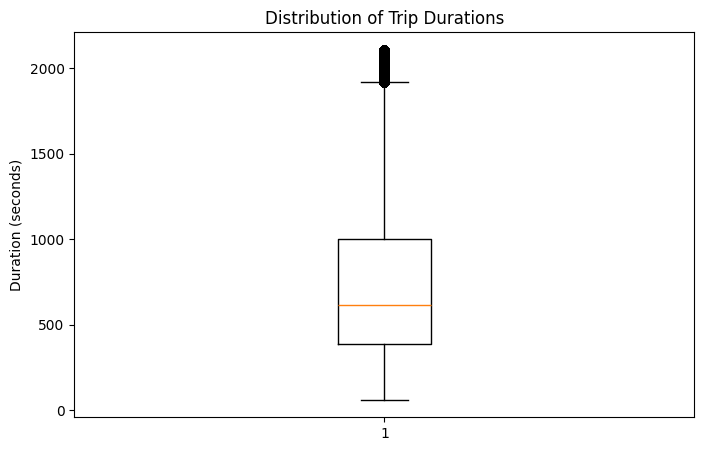

In [46]:
# Show outliers in duration column and remove them

df_to_preprocess = joined_df.copy()
df_to_preprocess = df_to_preprocess[
    (df_to_preprocess["duration"] > 60) & (df_to_preprocess["duration"] < 86400)
]

Q1 = df_to_preprocess["duration"].quantile(0.25)
Q3 = df_to_preprocess["duration"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_to_preprocess = df_to_preprocess[
    (df_to_preprocess["duration"] >= lower_bound)
    & (df_to_preprocess["duration"] <= upper_bound)
]

print("Duration statistics:")
print(f"Q1: {Q1:.2f}")
print(f"Q3: {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")

plt.figure(figsize=(8, 5))
plt.boxplot(df_to_preprocess["duration"])
plt.title("Distribution of Trip Durations")
plt.ylabel("Duration (seconds)")

plt.savefig("artifacts/duration_boxplot.png")

In [47]:
# Create month, week_day, and is_holiday features based on start_date

df_to_preprocess["month"] = df_to_preprocess["start_date"].dt.month
df_to_preprocess["week_day"] = df_to_preprocess["start_date"].dt.day_name()
cal = USFederalHolidayCalendar()
holidays = cal.holidays(
    start=df_to_preprocess["start_date"].min(), end=df_to_preprocess["start_date"].max()
)

df_to_preprocess["is_holiday"] = (
    df_to_preprocess["start_date"].dt.date.isin(holidays.date).astype(int)
)

df_to_preprocess["hour"] = df_to_preprocess["start_date"].dt.hour
df_to_preprocess["peak_time"] = (
    ((df_to_preprocess["hour"] >= 7) & (df_to_preprocess["hour"] <= 9))
    | ((df_to_preprocess["hour"] >= 16) & (df_to_preprocess["hour"] <= 19))
).astype(int)
df_to_preprocess.drop(columns=["hour"], inplace=True)

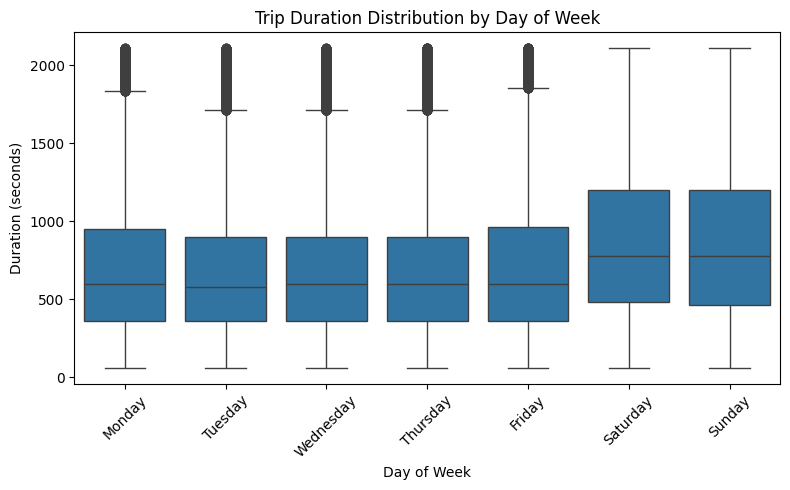

In [48]:
# Plot duration by day of week

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_to_preprocess,
    x="week_day",
    y="duration",
    order=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
)
plt.title("Trip Duration Distribution by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Duration (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("artifacts/duration_by_day_of_week.png")

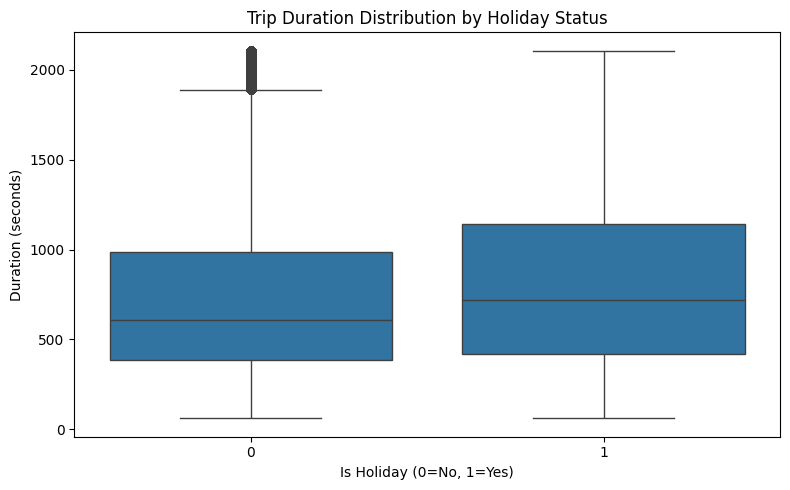

In [49]:
# Plot duration by holiday

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_to_preprocess, x="is_holiday", y="duration")
plt.title("Trip Duration Distribution by Holiday Status")
plt.xlabel("Is Holiday (0=No, 1=Yes)")
plt.ylabel("Duration (seconds)")
plt.tight_layout()

plt.savefig("artifacts/duration_by_holiday.png")

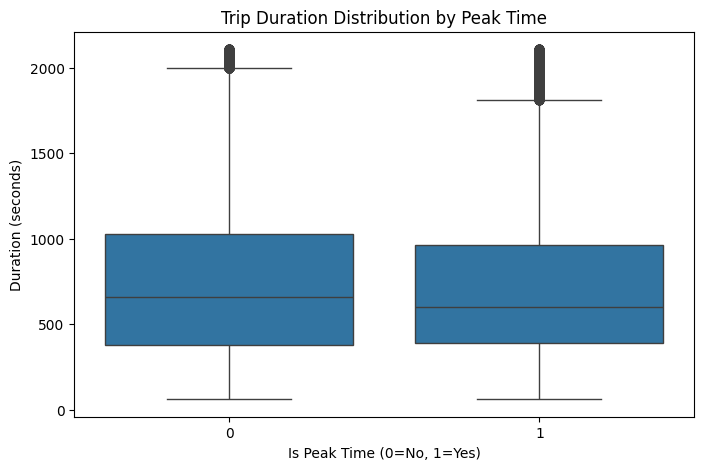

In [50]:
# Plot duration by peak time

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_to_preprocess, x="peak_time", y="duration")
plt.title("Trip Duration Distribution by Peak Time")
plt.xlabel("Is Peak Time (0=No, 1=Yes)")
plt.ylabel("Duration (seconds)")

plt.savefig("artifacts/duration_by_peak_time.png")

In [51]:
# Calculate distance between start and end hubs, and create distance feature


def calculate_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r


df_to_preprocess["distance"] = calculate_distance(
    df_to_preprocess["start_lat"],
    df_to_preprocess["start_lng"],
    df_to_preprocess["end_lat"],
    df_to_preprocess["end_lng"],
)

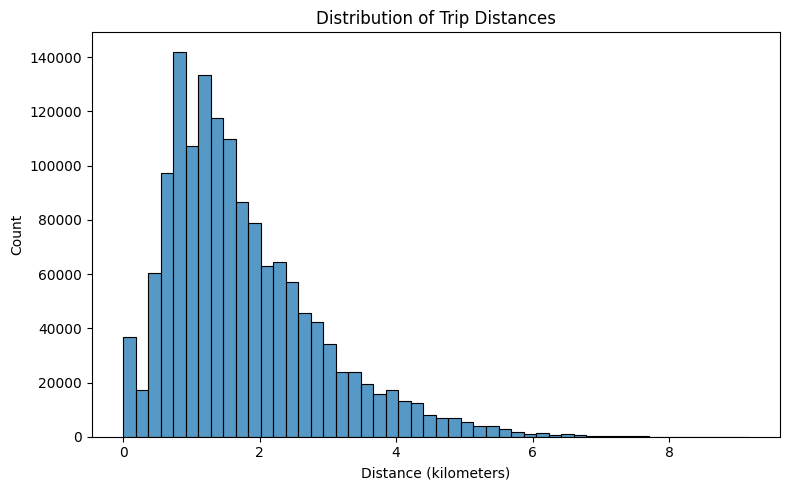

In [52]:
# Plot distribution of distance

plt.figure(figsize=(8, 5))
sns.histplot(data=df_to_preprocess, x="distance", bins=50)
plt.title("Distribution of Trip Distances")
plt.xlabel("Distance (kilometers)")
plt.ylabel("Count")
plt.tight_layout()

plt.savefig("artifacts/distance_distribution.png")

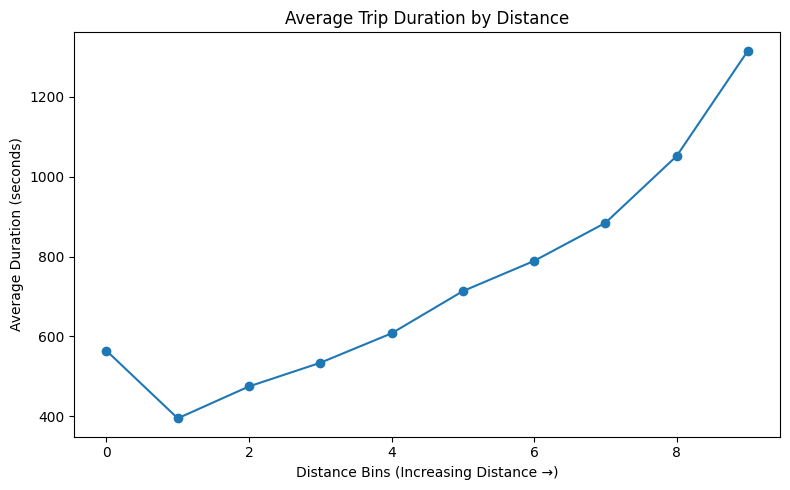

In [53]:
# Plot duration by distance

plt.figure(figsize=(8, 5))
df_to_preprocess["distance_bins"] = pd.qcut(df_to_preprocess["distance"], q=10)
avg_duration_by_dist = df_to_preprocess.groupby("distance_bins")["duration"].mean()
plt.plot(range(10), avg_duration_by_dist.values, marker="o")
plt.title("Average Trip Duration by Distance")
plt.xlabel("Distance Bins (Increasing Distance →)")
plt.ylabel("Average Duration (seconds)")
plt.tight_layout()

plt.savefig("artifacts/duration_by_distance.png")

df_to_preprocess.drop(columns=["distance_bins"], inplace=True)

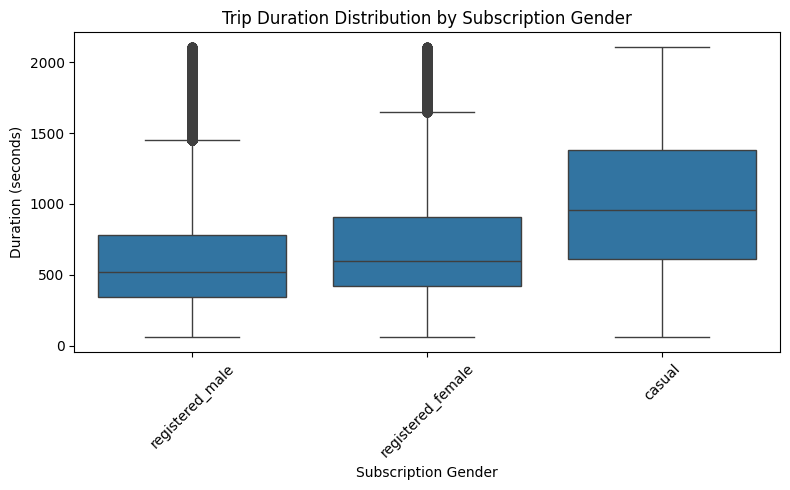

In [54]:
# Create a subscription_gender feature based on subscription type and gender

conditions = [
    (df_to_preprocess["subsc_type"] == "Registered")
    & (df_to_preprocess["gender"] == "Male"),
    (df_to_preprocess["subsc_type"] == "Registered")
    & (df_to_preprocess["gender"] == "Female"),
]
choices = ["registered_male", "registered_female"]
df_to_preprocess["subscription_gender"] = np.select(
    conditions, choices, default="casual"
)
df_to_preprocess.drop(columns=["gender", "subsc_type"], inplace=True)


plt.figure(figsize=(8, 5))
sns.boxplot(data=df_to_preprocess, x="subscription_gender", y="duration")
plt.title("Trip Duration Distribution by Subscription Gender")
plt.xlabel("Subscription Gender")
plt.ylabel("Duration (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("artifacts/duration_by_subscription_gender.png")

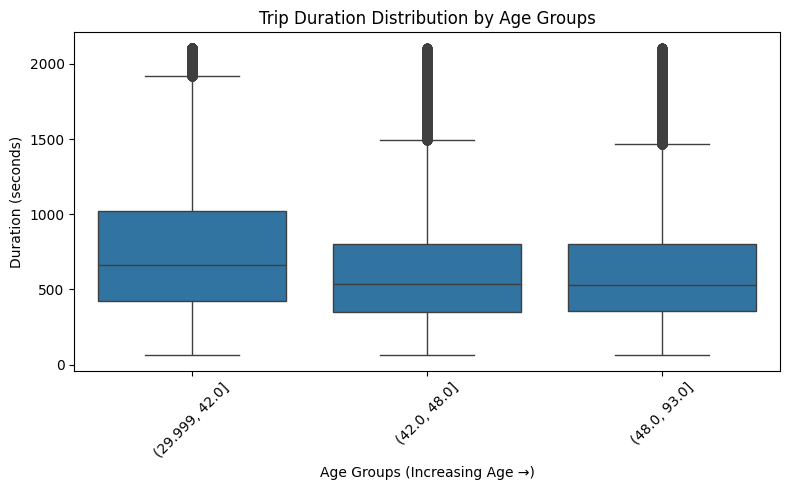

In [55]:
# Calculate age using birth_date and replace missing values with mode, then create age feature

current_year = pd.Timestamp.now().year
df_to_preprocess["age"] = current_year - df_to_preprocess["birth_date"]
age_mode = df_to_preprocess["age"].mode()[0]
df_to_preprocess["age"] = df_to_preprocess["age"].fillna(age_mode)
df_to_preprocess.drop(columns=["birth_date"], inplace=True)

plt.figure(figsize=(8, 5))
df_to_preprocess["age_bins"] = pd.qcut(df_to_preprocess["age"], q=10, duplicates="drop")
sns.boxplot(data=df_to_preprocess, x="age_bins", y="duration")
plt.title("Trip Duration Distribution by Age Groups")
plt.xlabel("Age Groups (Increasing Age →)")
plt.ylabel("Duration (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("artifacts/duration_by_age.png")

df_to_preprocess.drop(columns=["age_bins"], inplace=True)

In [56]:
# Data with additional features from feature engineering

df_to_preprocess.head()

,duration,start_date,strt_statn,end_date,end_statn,start_municipal,start_lat,start_lng,start_status,end_municipal,end_lat,end_lng,end_status,start_date_formatted,DATE,HPCP,month,week_day,is_holiday,peak_time,distance,subscription_gender,age
1,220,2011-07-28 10:21:00,23.0,7/28/2011 10:25:00,23.0,Boston,42.359677,-71.059364,Removed,Boston,42.359677,-71.059364,Removed,20110728 10:00,NaN,NaN,7,Thursday,0,0,0.000000,registered_male,59.0
3,64,2011-07-28 10:35:00,23.0,7/28/2011 10:36:00,23.0,Boston,42.359677,-71.059364,Removed,Boston,42.359677,-71.059364,Removed,20110728 10:00,NaN,NaN,7,Thursday,0,0,0.000000,registered_female,44.0
9,1108,2011-07-28 11:55:00,47.0,7/28/2011 12:13:00,40.0,Boston,42.362811,-71.056067,Existing,Boston,42.363871,-71.050877,Existing,20110728 11:00,NaN,NaN,7,Thursday,0,0,0.442403,registered_male,31.0
10,1055,2011-07-28 11:55:00,47.0,7/28/2011 12:13:00,40.0,Boston,42.362811,-71.056067,Existing,Boston,42.363871,-71.050877,Existing,20110728 11:00,NaN,NaN,7,Thursday,0,0,0.442403,registered_male,69.0
11,1042,2011-07-28 11:55:00,47.0,7/28/2011 12:12:00,40.0,Boston,42.362811,-71.056067,Existing,Boston,42.363871,-71.050877,Existing,20110728 11:00,NaN,NaN,7,Thursday,0,0,0.442403,registered_female,66.0


In [57]:
# Save data to csv


def write_to_csv(df_to_save, file_name):
    project_path = os.getcwd()
    data_path = os.path.join(project_path, "data")
    return df_to_save.to_csv(os.path.join(data_path, file_name), index=False)


write_to_csv(df_to_preprocess, "df_to_preprocess.csv")

In [59]:
# create model basefile: drop columns that are not needed for the model, and change data types


def create_model_basefile(input_df):
    model_basefile = load_data(
        input_df,
        col_to_drop=[
            "start_date",
            "strt_statn",
            "end_date",
            "end_statn",
            "start_lat",
            "start_lng",
            "end_lat",
            "end_lng",
            "start_date_formatted",
            "DATE",
        ],
    ).dropna()

    model_basefile["month"] = model_basefile["month"].astype("category")
    model_basefile["week_day"] = model_basefile["week_day"].astype("category")
    model_basefile["is_holiday"] = model_basefile["is_holiday"].astype("category")
    model_basefile["peak_time"] = model_basefile["peak_time"].astype("category")
    model_basefile.info()
    return model_basefile


model_basefile = create_model_basefile("df_to_preprocess.csv")

/var/folders/pn/pl6qnr8s151_nqvmrz6hd0tm0000gn/T/ipykernel_43993/1276208376.py:7: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(os.path.join(data_path, file_name)).drop(columns=col_to_drop)


<class 'pandas.core.frame.DataFrame'>
Index: 80795 entries, 406 to 955371
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   duration             80795 non-null  int64   
 1   start_municipal      80795 non-null  object  
 2   start_status         80795 non-null  object  
 3   end_municipal        80795 non-null  object  
 4   end_status           80795 non-null  object  
 5   HPCP                 80795 non-null  float64 
 6   month                80795 non-null  category
 7   week_day             80795 non-null  category
 8   is_holiday           80795 non-null  category
 9   peak_time            80795 non-null  category
 10  distance             80795 non-null  float64 
 11  subscription_gender  80795 non-null  object  
 12  age                  80795 non-null  float64 
dtypes: category(4), float64(3), int64(1), object(5)
memory usage: 6.5+ MB


In [60]:
# Create the model train pipeline:
## Sample the data to reduce the training time
## Split the data into training and test sets
## Define a preprocessor for the model
## Define a model pipeline with the preprocessor and the regressor
## preprocessor: for numerical features, standardize the data, for categorical features, one-hot encode the data
## Three types of regressors included: Linear Regression, Random Forest, and XGBoost
## Define the search space for the hyperparameters tuning
## Define the bayes search with cross validation for the model


def model_pipeline(model_basefile):
    model_basefile_sample = model_basefile.sample(frac=0.05, random_state=123)
    X = model_basefile_sample.drop("duration", axis=1)
    y = np.log(model_basefile_sample["duration"])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=123
    )

    numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
    categorical_features = X.select_dtypes(include=["category", "object"]).columns
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            (
                "cat",
                OneHotEncoder(drop="first", sparse_output=False),
                categorical_features,
            ),
        ]
    )

    lr_pipeline = Pipeline(
        [("preprocessor", preprocessor), ("regressor", LinearRegression())]
    )

    rf_pipeline = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("regressor", RandomForestRegressor(random_state=123)),
        ]
    )

    xgb_pipeline = Pipeline(
        [("preprocessor", preprocessor), ("regressor", XGBRegressor(random_state=123))]
    )

    lr_search_space = {
        "regressor__fit_intercept": Categorical([True, False]),
    }

    rf_search_space = {
        "regressor__n_estimators": Integer(100, 300),
        "regressor__max_depth": Integer(3, 20),
    }

    xgb_search_space = {
        "regressor__n_estimators": Integer(100, 300),
        "regressor__max_depth": Integer(3, 20),
    }

    lr_search = BayesSearchCV(
        lr_pipeline, lr_search_space, n_iter=20, cv=3, n_jobs=-1, random_state=123
    )

    rf_search = BayesSearchCV(
        rf_pipeline, rf_search_space, n_iter=20, cv=3, n_jobs=-1, random_state=123
    )

    xgb_search = BayesSearchCV(
        xgb_pipeline, xgb_search_space, n_iter=20, cv=3, n_jobs=-1, random_state=123
    )

    return lr_search, rf_search, xgb_search, X_train, X_test, y_train, y_test


lr_search, rf_search, xgb_search, X_train, X_test, y_train, y_test = model_pipeline(
    model_basefile
)

In [61]:
# train pipeline run:
## Train models with bayes search for three types of regressors
## Save the best model to the artifacts
## Save the model scores to the artifacts


def pipeline_run(lr_search, rf_search, xgb_search, X_train, X_test, y_train, y_test):
    print("Training Linear Regression...")
    lr_search.fit(X_train, y_train)

    print("\nTraining Random Forest...")
    rf_search.fit(X_train, y_train)

    print("\nTraining XGBoost...")
    xgb_search.fit(X_train, y_train)

    models = {
        "Linear Regression": lr_search,
        "Random Forest": rf_search,
        "XGBoost": xgb_search,
    }

    test_scores = {}
    for name, model in models.items():
        print(f"\n{name} Results:")
        print(f"Best score: {model.best_score_:.3f}")
        print("Best parameters:", model.best_params_)
        y_pred = model.predict(X_test)
        test_scores[name] = r2_score(y_test, y_pred)
        print(f"Test R2 Score: {test_scores[name]:.3f}")
        print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

    best_model_name = max(test_scores, key=test_scores.get)
    best_model = models[best_model_name]

    project_path = os.getcwd()
    artifacts_path = os.path.join(project_path, "artifacts")
    model_path = os.path.join(artifacts_path, "best_model.pkl")
    joblib.dump(best_model, model_path)
    print(f"\nBest model ({best_model_name}) saved to {model_path}")
    test_scores_path = os.path.join(artifacts_path, "model_scores.json")
    with open(test_scores_path, "w") as f:
        json.dump(test_scores, f, indent=2)
    print(f"\nModel scores saved to {test_scores_path}")


pipeline_run(lr_search, rf_search, xgb_search, X_train, X_test, y_train, y_test)

Training Linear Regression...

Training Random Forest...

Training XGBoost...

Linear Regression Results:
Best score: 0.541
Best parameters: OrderedDict({'regressor__fit_intercept': True})
Test R2 Score: 0.474
Test RMSE: 0.441

Random Forest Results:
Best score: 0.643
Best parameters: OrderedDict({'regressor__max_depth': 5, 'regressor__n_estimators': 300})
Test R2 Score: 0.659
Test RMSE: 0.355

XGBoost Results:
Best score: 0.626
Best parameters: OrderedDict({'regressor__max_depth': 3, 'regressor__n_estimators': 101})
Test R2 Score: 0.620
Test RMSE: 0.375

Best model (Random Forest) saved to /Users/frank/Desktop/Dev/Bike-Task/artifacts/best_model.pkl

Model scores saved to /Users/frank/Desktop/Dev/Bike-Task/artifacts/model_scores.json


,feature,importance
9,distance,1.136369
10,subscription_gender,0.168750
6,week_day,0.004648
5,month,0.002504
4,HPCP,0.000940
3,end_status,0.000055
8,peak_time,0.000038
7,is_holiday,0.000000
11,age,-0.000005
1,start_status,-0.000008


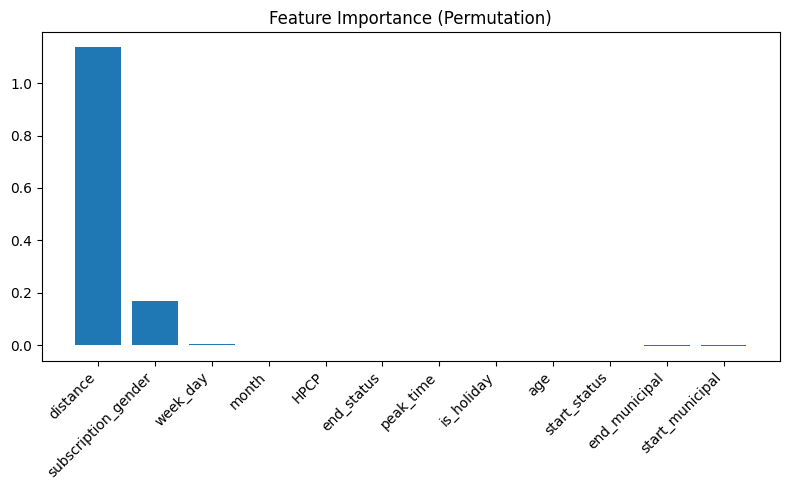

In [62]:
# Get permutation importance from the model


def get_permutation_importance(X_test, y_test):
    project_path = os.getcwd()
    artifacts_path = os.path.join(project_path, "artifacts")
    loaded_model = joblib.load(os.path.join(artifacts_path, "best_model.pkl"))
    result = permutation_importance(
        loaded_model, X_test, y_test, n_repeats=10, random_state=42
    )
    feature_importance = pd.DataFrame(
        {"feature": X_test.columns, "importance": result.importances_mean}
    )
    feature_importance = feature_importance.sort_values("importance", ascending=False)

    plt.figure(figsize=(8, 5))
    plt.bar(feature_importance["feature"], feature_importance["importance"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Feature Importance (Permutation)")
    plt.tight_layout()
    plt.savefig(os.path.join(artifacts_path, "feature_importance.png"))
    return feature_importance


feature_importance_df = get_permutation_importance(X_test, y_test)
feature_importance_df

In [63]:
# Model prediction
## Load the best model from the artifacts
## Predict using the test set


def model_prediction(X_test, y_test):
    project_path = os.getcwd()
    artifacts_path = os.path.join(project_path, "artifacts")
    loaded_model = joblib.load(os.path.join(artifacts_path, "best_model.pkl"))

    y_pred = loaded_model.predict(X_test)
    print("Best Model Performance:")
    print(f"R2 Score: {r2_score(y_test, y_pred):.3f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
    return pd.DataFrame({"duration": np.exp(y_test), "duration_pred": np.exp(y_pred)})


prediction_df = model_prediction(X_test, y_test)
prediction_df.head()

Best Model Performance:
R2 Score: 0.659
RMSE: 0.355


,duration,duration_pred
898383,480.0,453.457617
431470,549.0,448.493070
815758,1620.0,906.440937
498342,1020.0,710.265829
262569,502.0,683.137269
